
# Generiranje učnih slik in šuma (brez nevronske mreže)

Ta zvezek generira sintetične učne podatke z **trikotniki, štirikotniki, elipsami in zvezdami**, naključnimi barvami in doda **aditivni** ter **multiplikativni** šum.  
Velikost slik: **256×256**. Za vsak tip lika narišemo **5 primerkov**.

> Opomba: Če knjižnica OpenCV ni na voljo, se proti-aliasing doseže s supersamplingu (risanje v večji ločljivosti in pomanjšanje).


In [2]:
import math
import numpy as np
from PIL import Image, ImageDraw
import cv2

rng = np.random.default_rng()

def rand_color():
    return tuple(int(x) for x in rng.integers(0, 256, size=3))

def _rgb_to_bgr(c):  # because OpenCV expects BGR, but your arrays are RGB
    return (int(c[2]), int(c[1]), int(c[0]))

def random_point(W, H):
    return (int(rng.integers(0, W)),
            int(rng.integers(0, H)))

def gen_polygon_points(n, W, H):
    pts = np.array([random_point(W, H) for _ in range(n)], dtype=np.int32)
    cx, cy = pts[:,0].mean(), pts[:,1].mean()
    ang = np.arctan2(pts[:,1] - cy, pts[:,0] - cx)
    order = np.argsort(ang)
    return pts[order]

def draw_triangle(img_np, color):
    H, W = img_np.shape[:2]
    pts = gen_polygon_points(3, W, H).reshape(-1, 1, 2)
    cv2.fillPoly(img_np, [pts], _rgb_to_bgr(color), lineType=cv2.LINE_AA)

def draw_quadrilateral(img_np, color):
    H, W = img_np.shape[:2]
    pts = gen_polygon_points(4, W, H).reshape(-1, 1, 2)
    cv2.fillPoly(img_np, [pts], _rgb_to_bgr(color), lineType=cv2.LINE_AA)

def draw_ellipse(img_np, color):
    H, W = img_np.shape[:2]
    cx, cy = random_point(W, H)
    rx = int(rng.integers(3, W/2))
    ry = int(rng.integers(3, H/2))
    angle = float(rng.uniform(0, 180))
    cv2.ellipse(
        img_np,
        (cx, cy), (rx, ry),
        angle, 0, 360,
        _rgb_to_bgr(color),
        thickness=-1,
        lineType=cv2.LINE_AA
    )

def draw_star(img_np, color):
    H, W = img_np.shape[:2]
    cx, cy = random_point(W, H)
    bgr = _rgb_to_bgr(color)
    for _ in range(5):
        x2, y2 = random_point(W, H)
        cv2.line(img_np, (cx, cy), (x2, y2), bgr, thickness=1, lineType=cv2.LINE_AA)

# --- generators ---
def generate_clean_image(size=256, per_shape=5):
    img = np.zeros((size, size, 3), dtype=np.uint8)
    img[:] = rand_color()
    for _ in range(per_shape):
        draw_triangle(img, rand_color())
        draw_quadrilateral(img, rand_color())
        draw_ellipse(img, rand_color())
        draw_star(img, rand_color())
    return img

def to_float01(img_u8): 
    return img_u8.astype(np.float32) / 255.0

def to_uint8(img_f):
    return (np.clip(img_f, 0.0, 1.0) * 255.0 + 0.5).astype(np.uint8)

def add_additive_noise(img_u8):
    x = to_float01(img_u8)
    sigma = float(rng.uniform(0.1, 0.3))
    n = rng.normal(0.0, sigma, size=x.shape).astype(np.float32)
    y = x + n
    return to_uint8(y), sigma

def add_multiplicative_noise(img_u8):
    x = to_float01(img_u8)
    sigma = float(rng.uniform(0.1, 0.3))
    n = rng.normal(1.0, sigma, size=x.shape).astype(np.float32)
    y = x * n
    return to_uint8(y), sigma



## Primer: generiraj eno sliko in dodaj šum


Aditivni šum σ ≈ 0.29 | Multiplikativni šum σ ≈ 0.16
✅ Saved images as:
   • clean_image.png
   • blurry_image.png


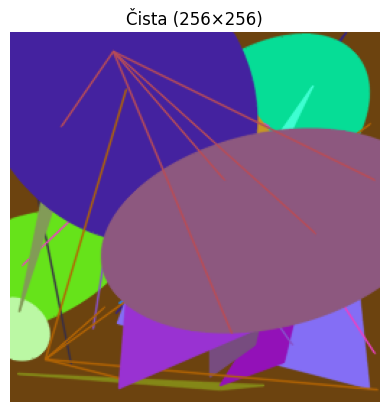

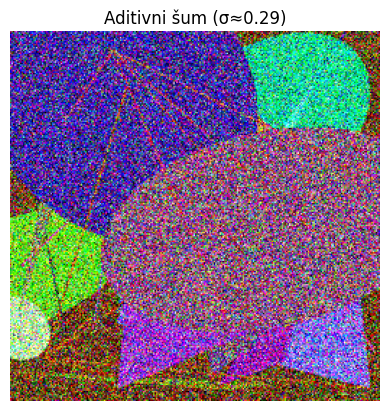

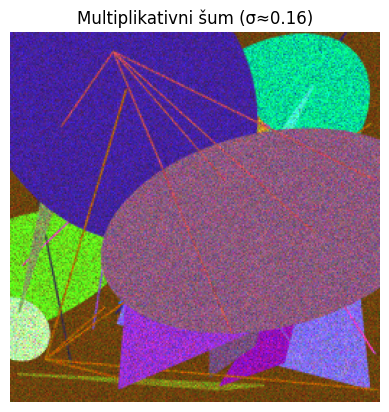

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

# --- generate images ---
clean = generate_clean_image(size=256, per_shape=5)
add, s_add = add_additive_noise(clean)
mul, s_mul = add_multiplicative_noise(clean)

print(f"Aditivni šum σ ≈ {s_add:.2f} | Multiplikativni šum σ ≈ {s_mul:.2f}")

# --- visualize ---
plt.figure()
plt.imshow(clean); plt.axis("off"); plt.title("Čista (256×256)")

plt.figure()
plt.imshow(add); plt.axis("off"); plt.title(f"Aditivni šum (σ≈{s_add:.2f})")

plt.figure()
plt.imshow(mul); plt.axis("off"); plt.title(f"Multiplikativni šum (σ≈{s_mul:.2f})")

# --- save images ---
out_dir = Path(".")
clean_path = out_dir / "clean_image.png"
add_path   = out_dir / "blurry_image_additive.png"
mul_path   = out_dir / "blurry_image_multiplicative.png"

plt.imsave(clean_path, clean)
plt.imsave(add_path, add)
plt.imsave(mul_path, mul)

# (optional) choose which noisy image should be the default for downstream code
# set to "add" if you want the additive one to be used by your inference script
DEFAULT_NOISY = "mul"  # "add" or "mul"
default_noisy_path = out_dir / "blurry_image.png"
if DEFAULT_NOISY == "add":
    plt.imsave(default_noisy_path, add)
else:
    plt.imsave(default_noisy_path, mul)

print("✅ Saved images as:")
print(f"   • {clean_path.name}")
print(f"   • {add_path.name}")
print(f"   • {mul_path.name}")
print(f"   • {default_noisy_path.name} (points to: {DEFAULT_NOISY})")



## Ustvari in shrani n slik (čiste, z aditivnim in z multiplikativnim šumom)


In [70]:

from pathlib import Path
from PIL import Image

def generate_dataset(n=50, out_dir="dataset", size=256, per_shape=5):
    out_dir = Path(out_dir)
    (out_dir / "clean").mkdir(parents=True, exist_ok=True)
    (out_dir / "additive").mkdir(parents=True, exist_ok=True)
    (out_dir / "multiplicative").mkdir(parents=True, exist_ok=True)
    for i in range(n):
        clean = generate_clean_image(size=size, per_shape=per_shape)
        Image.fromarray(clean).save(out_dir / "clean" / f"img_{i:04d}.png")
        add, s1 = add_additive_noise(clean)
        mul, s2 = add_multiplicative_noise(clean)
        Image.fromarray(add).save(out_dir / "additive" / f"img_{i:04d}_add_{s1:.2f}.png")
        Image.fromarray(mul).save(out_dir / "multiplicative" / f"img_{i:04d}_mul_{s2:.2f}.png")

print("Funkcija generate_dataset je pripravljena.")
generate_dataset(10000)


Funkcija generate_dataset je pripravljena.
